# Calculate Gene mC Fractions

In [1]:
import pandas as pd
import scanpy as sc
import anndata
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds.MCDS import MCDS
import pathlib
import numpy as np

In [2]:
gene_meta_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM']

# change this to the path to your filtered metadata
metadata_path = 'CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files
mcds_path_list = [
    '../Data/3C-171206.mcds',
    '../Data/3C-171207.mcds',
    '../Data/9H-190212.mcds',
    '../Data/9H-190219.mcds',
]
obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5


## Load metadata

In [3]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 4958 cells


## Filter genes by overlap and chromosomes

In [5]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


41871 features remained


## Filter genes by cell mean coverage

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].
35664 features remained


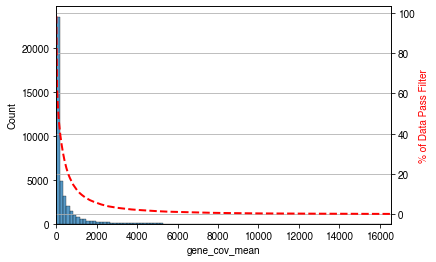

In [6]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list, obs_dim=obs_dim,
                     use_obs=metadata.index).sel({var_dim: use_features})
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

In [7]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 41871 gene
 After cov mean filter: 35664 gene 85.2%


<xarray.MCDS>
Dimensions:              (cell: 4958, chrom100k: 27269, count_type: 2, gene: 35664, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * cell                 (cell) object '3C_M_0' '3C_M_1' ... '9H_M_3061'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG000...
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object dask.array<chunksize=(35664,), meta=np.ndarray>
    gene_start           (gene) int64 dask.array<chunksize=(35664,), meta=np.ndarray>
    gene_end             (gene) int64 dask.array<chunksize=(35664,), meta=np.ndarray>
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 13.71 6.909e+03 ... 38.53 1.328e+03
Data variables:
    gene_da              (cell, gene, mc_type, count_type) uint16 dask.array<chunksize=(1199, 35664, 2, 2), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1199, 27269, 2, 2), meta=np.ndarray>

## Add Gene mC Fraction per MCDS file

In [8]:
gene_frac_dir = pathlib.Path('gene_frac')
gene_frac_dir.mkdir(exist_ok=True)

In [9]:
for mcds_path in mcds_path_list:
    output_path = gene_frac_dir / (pathlib.Path(mcds_path).name + f'{var_dim}_da_rate.nc')
    if output_path.exists():
        continue
    print(f'Computaing gene mC fraction for {mcds_path}')
    mcds = MCDS.open(mcds_path, obs_dim=obs_dim)
    # remove non-related data
    del_das = []
    for da in mcds:
        if da != f'{var_dim}_da':
            del_das.append(da)
    for da in del_das:
        del mcds[da]
    mcds.load()
    mcds = mcds.sel({var_dim: use_features})
    mcds.add_mc_rate(var_dim=var_dim, normalize_per_cell=True, clip_norm_value=10)
    # use float32 to reduce file size and speedup IO
    mcds = mcds.rename({var_dim: 'gene', f'{var_dim}_da_rate': 'gene_da_rate'})
    mcds['gene_da_rate'].astype('float32').to_netcdf(output_path)

## Save gene metadata together with gene fraction files

In [10]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(gene_frac_dir / 'GeneMetadata.csv.gz')

## How to create adata from gene mC frac files

### Create xr.DataArray (unloaded)

In [11]:
# gene_frac_paths = gene_frac_dir.glob('*_da_rate.nc')
# gene_frac_da = xr.open_mfdataset(gene_frac_paths, concat_dim='cell', combine='nested')['gene_da_rate']
# gene_frac_da

<xarray.DataArray 'gene_da_rate' (cell: 5127, gene: 35664, mc_type: 2)>
dask.array<concatenate, shape=(5127, 35664, 2), dtype=float32, chunksize=(1404, 35664, 2), chunktype=numpy.ndarray>
Coordinates:
  * mc_type      (mc_type) object 'CGN' 'CHN'
  * cell         (cell) object '3C_M_1015' '3C_M_0' ... '9H_M_3055' '9H_M_3057'
  * gene         (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000096768.8'
    strand_type  <U4 'both'
    gene_chrom   (gene) object dask.array<chunksize=(35664,), meta=np.ndarray>
    gene_start   (gene) int64 dask.array<chunksize=(35664,), meta=np.ndarray>
    gene_end     (gene) int64 dask.array<chunksize=(35664,), meta=np.ndarray>

### Create anndata.AnnData (only load used cells)

In [14]:
# use_metadata = metadata.iloc[:100, :]
# 
# example_adata = anndata.AnnData(
#     X=gene_frac_da.sel({
#         obs_dim: use_metadata.index,
#         'mc_type': 'CHN'
#     }).values,
#     obs=use_metadata,
#     var=use_gene_meta
#     )
# 
# example_adata

AnnData object with n_obs × n_vars = 100 × 35664
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag'